# Results with the Best Model

In this notebook. the best classifier will be used to detect the vehicles in the project video.

In [1]:
import glob
import pickle
import numpy as np
import timeit
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label

## Camera Calibration Functions

In [2]:
# a function to get calibration coeffs and camera matrix
def camera_calibration_params(images, nx, ny):
    """Get camera calibration parameters.
    
    This function uses several chessboard images and returns 
    the calibrations parameters which are camera matrix and
    calibration coefficients.
    
    Args:
        images: A list of strings defining the path of each image.
        nx: the number of corners along x-axis inside a chessboard.
        ny: the number of corners along y-axis inside a chessboard.
    """
    
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # prepare object points like (0, 0, 0), (1, 0, 0), 
    # (2, 0, 0), ..., (7, 5, 0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    ret = False
    c_mtx, dist = None, None
    for path in images:
        img = cv2.imread(path)
        # use `COLOR_RGB2GRAY` if read by `matplotlib.image.imread`
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if corners are found, add object and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp) # all object points will be the same for each imgpoints
            print('corners found for image: ' + path)
            # draw and display corners
            #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
            #plt.show()
            #plt.close()

    # now do the calibration, here c_mtx is the camera matrix
    # and dist are the distiortion coefficients
    # and rvecs is the rotation and the tvecs is the
    # translation vectors.
    if ret:
        ret, c_mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, c_mtx, dist

# a function to undistort the raw images
def undistort(raw, c_mtx, dist):
    """Undistort raw camera images.
    
    This function uses the camera matrix (c_mtx), distortion
    coefficients (dist) to undistort raw camera images.
    
    Returns RGB images!
    
    Args:
        raw (ndarray): The image taken by the cameraof which no 
            distortion correction applied. Image should be in `RGB` 
            format, read with `matplotlib.image.imread`.
            
        c_mtx: Camera calibration matrix, can be obtained using the
            `cv2.calibrateCamera` module.
        
        dist: Distortion coefficients, can be obtained using the
            `cv2.calibrateCamera` module.
    """
    
    # get undistorted destination image
    undist = cv2.undistort(raw, c_mtx, dist, None, c_mtx)
    
    return undist

In [3]:
# get calibration parameters using the chessboard images.
calibration_imgs = glob.glob('./camera_cal/calibration*.jpg')
ny = 9
nx = 6

ret, c_mtx, dist = camera_calibration_params(calibration_imgs, nx, ny)

cal_result = 'computed.' if ret else 'not computed.'

print('')
print('Camera matrix (c_mtx) and distortion coefficients (dist) are ' + cal_result)
print('c_mtx = ' + str(c_mtx))
print('dist = ' + str(dist))

corners found for image: ./camera_cal/calibration12.jpg
corners found for image: ./camera_cal/calibration3.jpg
corners found for image: ./camera_cal/calibration9.jpg
corners found for image: ./camera_cal/calibration13.jpg
corners found for image: ./camera_cal/calibration20.jpg
corners found for image: ./camera_cal/calibration19.jpg
corners found for image: ./camera_cal/calibration14.jpg
corners found for image: ./camera_cal/calibration16.jpg
corners found for image: ./camera_cal/calibration11.jpg
corners found for image: ./camera_cal/calibration10.jpg
corners found for image: ./camera_cal/calibration6.jpg
corners found for image: ./camera_cal/calibration15.jpg
corners found for image: ./camera_cal/calibration7.jpg
corners found for image: ./camera_cal/calibration2.jpg
corners found for image: ./camera_cal/calibration8.jpg
corners found for image: ./camera_cal/calibration18.jpg
corners found for image: ./camera_cal/calibration17.jpg

Camera matrix (c_mtx) and distortion coefficients (di

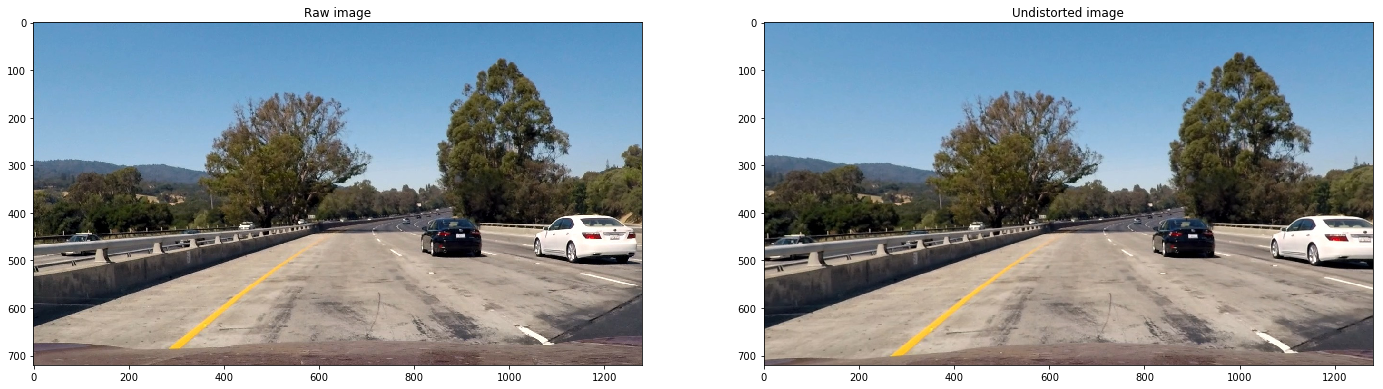

In [4]:
# undistort a test image
# load test image
test1 = mpimg.imread('./test_images/test1.jpg')

undist_test1 = undistort(test1, c_mtx, dist)

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(test1)
plt.title('Raw image')
plt.subplot(122)
plt.imshow(undist_test1)
plt.title('Undistorted image')
plt.show()
plt.close()

## Load The Classifiers

Load the classifier trained with the best dataset and the classifier trained with the augmented best dataset.

In [5]:
# Load Classifier
clf_path = './clfs/clf-c-10-kernel-rbf-gamma-auto-pix-16-16-cell-2-2-histeq-1.pkl'
clf_aug_path =\
    './clfs/clf-augmented-c-10-kernel-rbf-gamma-auto-pix-16-16-cell-2-2-histeq-1.pkl'
clf_extra_aug_path =\
    './clfs/clf-extra-augmented-c-10-kernel-rbf-gamma-auto-pix-16-16-cell-2-2-histeq-1.pkl'
with open(clf_path, mode='rb') as f:
    clf = pickle.load(f)
    print('clf loaded.')
with open(clf_aug_path, mode='rb') as f:
    clf_aug = pickle.load(f)
    print('clf (with augmented dataset) loaded.')
with open(clf_aug_path, mode='rb') as f:
    clf_extra_aug = pickle.load(f)
    print('clf (with extra augmented dataset) loaded.')

# load X scaler
scaler_path = './datasets/rgb/X-scaler-dataset-pix-16-16-cell-2-2-histeq-1.pkl'
scaler_aug_path =\
    './datasets/rgb/X-scaler-augmented-dataset-pix-16-16-cell-2-2-histeq-1.pkl'
scaler_extra_aug_path =\
    './datasets/rgb/X-scaler-extra-augmented-dataset-pix-16-16-cell-2-2-histeq-1.pkl'
with open(scaler_path, mode='rb') as f:
    X_scaler = pickle.load(f)
    print('X scaler loaded.')
with open(scaler_aug_path, mode='rb') as f:
    X_scaler_aug = pickle.load(f)
    print('X scaler (with augmented dataset) loaded.')
with open(scaler_aug_path, mode='rb') as f:
    X_scaler_extra_aug = pickle.load(f)
    print('X scaler (with extra augmented dataset) loaded.')

clf loaded.
clf (with augmented dataset) loaded.
clf (with extra augmented dataset) loaded.
X scaler loaded.
X scaler (with augmented dataset) loaded.
X scaler (with extra augmented dataset) loaded.


## Helper functions

In [10]:
def combine_images(img, heatmap):
    """Combine the image with the heatmap for the final video frames."""
    
    heatmap = cv2.resize(heatmap, (640, 360))
    img_small = cv2.resize(img, (640, 360))
    ratio = 250/heatmap.max()
    zero_img = np.zeros_like(heatmap)
    heatmap_rgb = np.dstack(((heatmap*ratio).astype(np.uint8), zero_img, zero_img))
    final_heatmap = cv2.addWeighted(heatmap_rgb, 0.9, img_small, 0.08, 0.)
    img[0:360, 0:640, :] = final_heatmap
    return img

In [11]:
# define a function to get hog feature
def get_hog(img, pix_per_cell=(8,8),
    cell_per_block=(2,2), orient=9,
    output_img=False, feature_vector=True):
    """Get HOG feature as flat array.
    
    Returns features as flattened array and the hog image.
    
    Args:
        pix_per_cell(tuple): 2-tuple, specifies the cell size over which each 
            gradient histogram is computed.
        cells_per_block(tuple): 2-tuple, specifies the local area over which 
            the histogram counts in a given cell will be normalized. 
        orient(int): Represents the number of orientation bins.
        output_img(bool): If `False` hog image will not be returned.
    """
    
    if output_img:
        features, hog_image = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=True, feature_vector=feature_vector, block_norm='L2-Hys')
        
        return features, hog_image
    else:
        features = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=False, feature_vector=feature_vector, block_norm='L2-Hys')
        
        return features

In [12]:
# define the feature extraction function
def get_features(img):
    
    def convert2uin8(img):
        return np.uint8(255 * img / np.max(img))
    
    # if not, convert to unint8
    if img.dtype != np.dtype(np.uint8):
        img = convert2uin8(img)
    
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    ch1 = cv2.equalizeHist(ch1)
    ch2 = cv2.equalizeHist(ch2)
    ch3 = cv2.equalizeHist(ch3)
    features1 = get_hog(
        ch1, pix_per_cell=(16,16),
        cell_per_block=(2,2), output_img=False,
        feature_vector=True)
    features2 = get_hog(
        ch2, pix_per_cell=(16,16),
        cell_per_block=(2,2), output_img=False,
        feature_vector=True)
    features3 = get_hog(
        ch3, pix_per_cell=(16,16),
        cell_per_block=(2,2), output_img=False,
        feature_vector=True)
    features = np.hstack((features1, features2, features3)).reshape(1, -1)
    
    return features

## Car Search Algorithm

A final car search algorithm is implemented.

### Helper functions

In [13]:
def label_cars(heatmap, threshold=1):
    heatmap[heatmap <= threshold] = 0
    labelled, n_cars = label(heatmap)
    return labelled, n_cars
    
def draw_boxes(bbox_img, labelled, n_cars, heatmap=None):
    """Draw rectangles around cars.
    
    If heatmap is given (not `None`) a weighted average will
    be taken using the edge coordinates of heatmap layers.
    
    """
    # iterate through detected cars
    bboxes = []
    for car_number in range(1, n_cars+1):
        # find pixels with each car_number label value
        nonzero = (labelled == car_number).nonzero()
        # identify x and y
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        car_x1 = np.min(nonzerox)
        car_y1 = np.min(nonzeroy)
        car_x2 = np.max(nonzerox)
        car_y2 = np.max(nonzeroy)
        if heatmap == None:
            # define a bounding box based on min/max x and y
            bbox = ((car_x1, car_y1), (car_x2, car_y2))
            bboxes.append(bbox)
        else:
            # do a weighted averaging for bbox edges
            # get car region
            car_region = heatmap[car_y1:car_y2, car_x1:car_x2]
            x1_sum, y1_sum = 0., 0.
            x2_sum, y2_sum = 0., 0.
            weights_sum = 0.
            for i in range(1, car_region.max()+1):
                # get the layer with intensity values equal to i
                layer = (car_region == i).nonzero()
                if len(layer[0]) > 0 and len(layer[1]) > 0:
                    # identify x and y
                    layery = np.array(layer[0])
                    layerx = np.array(layer[1])
                    # find x1,y1 and x2,y2
                    x1_sum = x1_sum + (car_x1+np.min(layerx))*i
                    y1_sum = y1_sum + (car_y1+np.min(layery))*i
                    x2_sum = x2_sum + (car_x1+np.max(layerx))*i
                    y2_sum = y2_sum + (car_y1+np.max(layery))*i
                    weights_sum = weights_sum + i
            bbox = (
                (np.int(x1_sum/weights_sum), np.int(y1_sum/weights_sum)),
                (np.int(x2_sum/weights_sum), np.int(y2_sum/weights_sum)))
            bboxes.append(bbox)
        # draw the box
        cv2.rectangle(bbox_img, bbox[0], bbox[1], (0,255,0), 6)
        
    return bbox_img, bboxes

implement the car search funtion.

In [14]:
# Define a single function that can extract features using hog
# sub-sampling and make predictions
def find_cars(
    img, ystart, ystop, scale, svc, X_scaler, orient, 
    pix_per_cell, cell_per_block, heatmap=None):
    
    def convert2uin8(img):
        return np.uint8(255 * img / np.max(img))
    
    # if not, convert to unint8
    if img.dtype != np.dtype(np.uint8):
        img = convert2uin8(img)
        
    img1 = cv2.equalizeHist(img[:,:,0])
    img2 = cv2.equalizeHist(img[:,:,1])
    img3 = cv2.equalizeHist(img[:,:,2])
    hist_eq = np.dstack((img1, img2, img3))
    
    draw_img = np.copy(img)
    bbox_img = np.copy(img)
    if heatmap == None:
        heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    
    region_tosearch = hist_eq[ystart:ystop,:,:]
    if scale != 1:
        imshape = region_tosearch.shape
        region_tosearch = cv2.resize(
            region_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = region_tosearch[:,:,0]
    ch2 = region_tosearch[:,:,1]
    ch3 = region_tosearch[:,:,2]

    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # 7
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 4 cells and 16 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 # 3
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog(
        ch1, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    hog2 = get_hog(
        ch2, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    hog3 = get_hog(
        ch3, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), orient,
        output_img=False, feature_vector=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract HOG for this patch
            hog_feat1 = hog1[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[
                ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                y1 = ytop_draw+ystart
                y2 = ytop_draw+win_draw+ystart
                x1 = xbox_left
                x2 = xbox_left+win_draw
                cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,0,255),6)
                heatmap[y1:y2, x1:x2] += 1
    
    # find islands on the heatmap and label
    labelled, n_cars = label_cars(heatmap, threshold=1)
    # draw regtangles (boxes) to these islands, if heatmap is given
    # (not None), then a weighted average will be taken.
    bbox_img, bboxes = draw_boxes(bbox_img, labelled, n_cars)
    
    return bbox_img, draw_img, heatmap, labelled, n_cars, bboxes

In [15]:
def multi_scale_find_cars(
    img, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    """Search for cars with multiple scales."""
    heatmap = None
    for scale in scale_list:
        bbox_img, out_img, heatmap, labelled, n_cars = find_cars(
            img, ystart, ystop, scale, svc, X_scaler, 
            orient, pix_per_cell, cell_per_block, heatmap)
    
    bbox_img = np.copy(img)
    
    labelled, n_cars = label_cars(heatmap, threshold=1)
    bbox_img, bboxes = draw_boxes(bbox_img, labelled, n_cars)
    
    return bbox_img, heatmap, labelled, n_cars, bboxes

## Test on images

Before the project video, test the results on a test image.

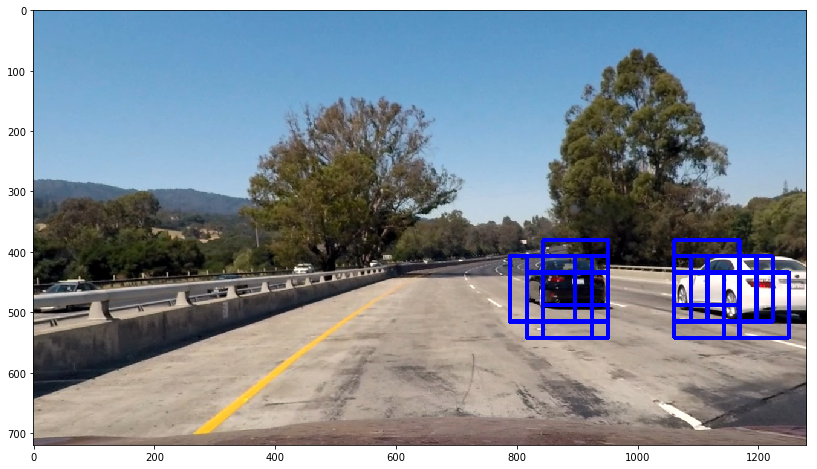

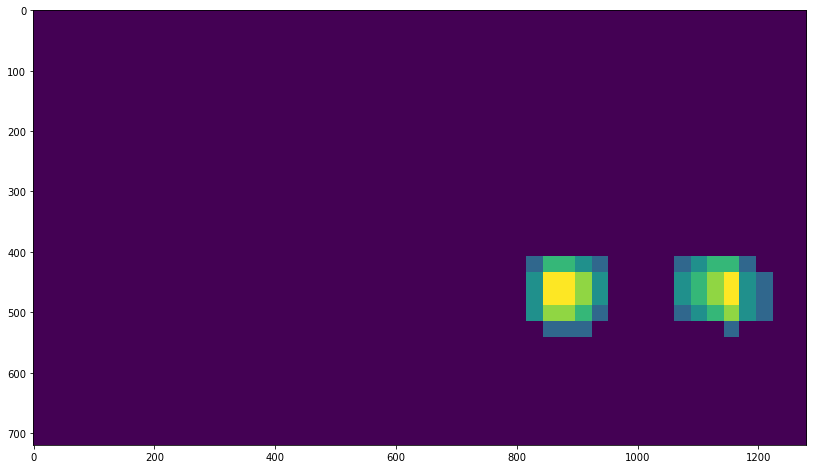

2 cars found.


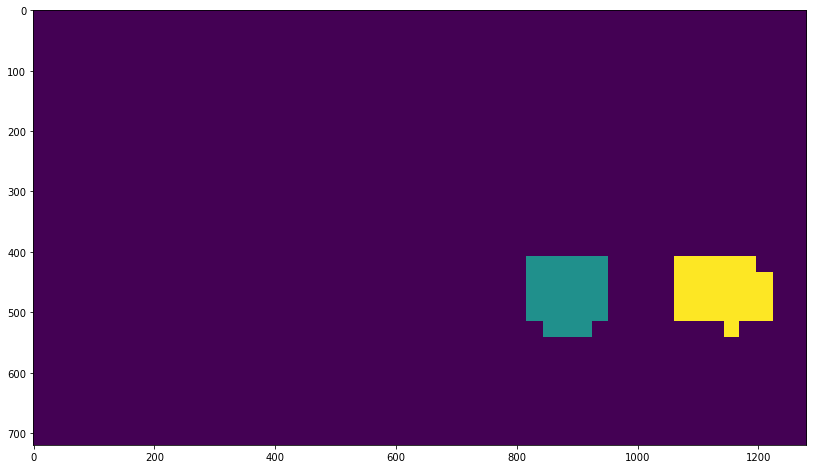

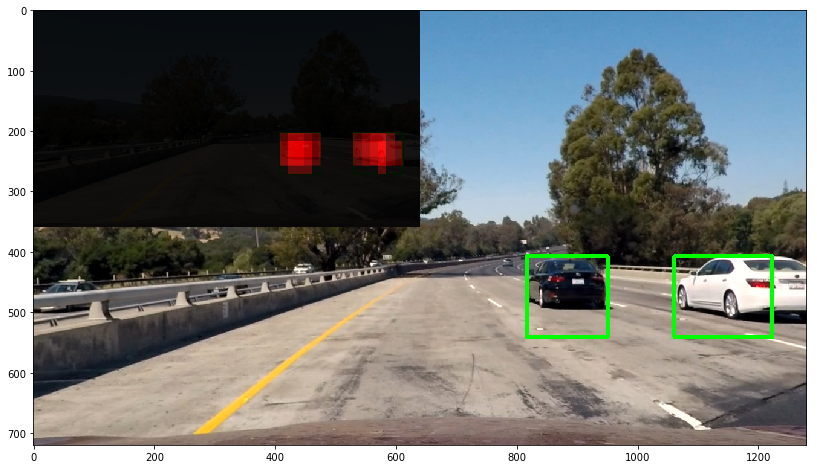

In [12]:
orient = 9
pix_per_cell = 16
cell_per_block = 2
ystart = 380
ystop = 700
scale = 1.7

#scale_list = [1.3, 1.4, 1.5, 1.6, 1.7]

bbox_img, out_img, heatmap, labelled, n_cars, bboxes = find_cars(
    undist_test1, ystart, ystop, scale, clf, X_scaler, orient, 
    pix_per_cell, cell_per_block)

#bbox_img, heatmap, labelled, n_cars, bboxes = multi_scale_find_cars(
#    undist_test1, ystart, ystop, scale_list, clf, X_scaler, orient, 
#    pix_per_cell, cell_per_block)

final_img = combine_images(bbox_img, heatmap)

plt.figure(figsize=(24,8))
plt.imshow(out_img)
plt.show()
plt.close()

plt.figure(figsize=(24,8))
plt.imshow(heatmap)
plt.show()
plt.close()

print(str(n_cars) + ' cars found.')
plt.figure(figsize=(24,8))
plt.imshow(labelled)
plt.show()
plt.close()

plt.figure(figsize=(24,8))
plt.imshow(final_img)
plt.show()
plt.close()

Now test for a specific car.

(108, 108, 3)
(64, 64, 3)


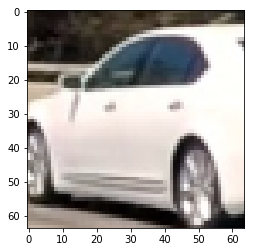

[ 1.]


In [13]:
#car = undist_test1[370:500,810:940]
car = undist_test1[400:508,1070:1178]
print(car.shape)
car = cv2.resize(car, (64,64))
print(car.shape)
plt.imshow(car)
plt.show()
plt.close()

hog_car = get_features(car)

# evaluate
# normalize test features
scaled_X_test = X_scaler.transform(hog_car)
# predict
y_pred = clf.predict(scaled_X_test)
print(y_pred)
#acc = accuracy_score(y_test, y_pred)

## Testing on video stream

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

### Use the model trained with the best dataset

In [15]:
# a history for consecutive 24 frames
bbox_history = deque(maxlen=24)

def process_image(image):
    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    ystart = 380
    ystop = 700
    scale = 1.7
    
    undist = undistort(image, c_mtx, dist)
    
    bbox_img, out_img, heatmap, labelled, n_cars, bboxes = find_cars(
        undist, ystart, ystop, scale, clf,
        X_scaler, orient, pix_per_cell, cell_per_block)
    
    #scale_list = [1.7]
    
    #bbox_img, heatmap, labelled, n_cars, bboxes = multi_scale_find_cars(
    #    undist, ystart, ystop, scale_list, clf,
    #    X_scaler, orient, pix_per_cell, cell_per_block)
    
    for i in range(n_cars):
        x1 = bboxes[i][0][0]
        y1 = bboxes[i][0][1]
        x2 = bboxes[i][1][0]
        y2 = bboxes[i][1][1]
        bbox_history.append([x1, y1, x2, y2])
        
    recent_boxes = np.array(bbox_history).tolist()
    
    # group boxes with the previous boxes from past frames.
    boxes = cv2.groupRectangles(recent_boxes, 7, .1)
    
    # draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(image, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
    
    final_img = combine_images(image, heatmap)
    
    return final_img

In [16]:
output = 'output_project_video.mp4'

clip = VideoFileClip("project_video.mp4")#.subclip(25, 35)
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [20:03<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 56min, sys: 1min 6s, total: 57min 7s
Wall time: 20min 4s


### Use the model trained with the augmented best dataset

In [17]:
# a history for consecutive 24 frames
bbox_history = deque(maxlen=24)

def process_image(image):
    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    ystart = 380
    ystop = 700
    scale = 1.7
    
    undist = undistort(image, c_mtx, dist)
    
    bbox_img, out_img, heatmap, labelled, n_cars, bboxes = find_cars(
        undist, ystart, ystop, scale, clf_aug,
        X_scaler_aug, orient, pix_per_cell, cell_per_block)
    
    #scale_list = [1.7]
    
    #bbox_img, heatmap, labelled, n_cars, bboxes = multi_scale_find_cars(
    #    undist, ystart, ystop, scale_list, clf_aug,
    #    X_scaler_aug, orient, pix_per_cell, cell_per_block)
    
    for i in range(n_cars):
        x1 = bboxes[i][0][0]
        y1 = bboxes[i][0][1]
        x2 = bboxes[i][1][0]
        y2 = bboxes[i][1][1]
        bbox_history.append([x1, y1, x2, y2])
        
    recent_boxes = np.array(bbox_history).tolist()
    
    # group boxes with the previous boxes from past frames.
    boxes = cv2.groupRectangles(recent_boxes, 7, .1)
    
    # draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(image, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
    
    final_img = combine_images(image, heatmap)
    
    return final_img

In [18]:
output = 'output_project_video_augmented.mp4'

clip = VideoFileClip("project_video.mp4")#.subclip(25, 35)
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video_augmented.mp4
[MoviePy] Writing video output_project_video_augmented.mp4


100%|█████████▉| 1260/1261 [19:14<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_augmented.mp4 

CPU times: user 55min 13s, sys: 1min 7s, total: 56min 21s
Wall time: 19min 15s


### Use the model trained with extra augmented best dataset

In [17]:
# a history for consecutive 24 frames
bbox_history = deque(maxlen=24)

def process_image(image):
    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    ystart = 380
    ystop = 700
    scale = 1.7
    
    undist = undistort(image, c_mtx, dist)
    
    bbox_img, out_img, heatmap, labelled, n_cars, bboxes = find_cars(
        undist, ystart, ystop, scale, clf_extra_aug,
        X_scaler_extra_aug, orient, pix_per_cell, cell_per_block)
    
    #scale_list = [1.7]
    
    #bbox_img, heatmap, labelled, n_cars, bboxes = multi_scale_find_cars(
    #    undist, ystart, ystop, scale_list, clf_extra_aug,
    #    X_scaler_extra_aug, orient, pix_per_cell, cell_per_block)
    
    for i in range(n_cars):
        x1 = bboxes[i][0][0]
        y1 = bboxes[i][0][1]
        x2 = bboxes[i][1][0]
        y2 = bboxes[i][1][1]
        bbox_history.append([x1, y1, x2, y2])
        
    recent_boxes = np.array(bbox_history).tolist()
    
    # group boxes with the previous boxes from past frames.
    boxes = cv2.groupRectangles(recent_boxes, 7, .1)
    
    # draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(image, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
    
    final_img = combine_images(image, heatmap)
    
    return final_img

In [18]:
output = 'output_project_video_extra_augmented.mp4'

clip = VideoFileClip("project_video.mp4")#.subclip(25, 35)
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video_augmented.mp4
[MoviePy] Writing video output_project_video_augmented.mp4


100%|█████████▉| 1260/1261 [22:08<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_augmented.mp4 

CPU times: user 57min 22s, sys: 1min 17s, total: 58min 40s
Wall time: 22min 9s


---